Enter area width  (e.g. 100) :  1000
Enter area height (e.g. 100) :  1000
Enter number of sensors (e.g. 5):  10
Enter minimum radius (e.g. 5) :  5
Enter maximum radius (e.g. 20):  20
Enter fixed part cost per sensor (e.g. 10):  100


Stopping search: reached max iterations (20)
Best Fitness = 987424000000.0923

 Final Covered Points (F2): 12576
 Total Cost (F1)          : 1160.00
 Cost per Covered Point   : 987424000000.0923
⏱ Hybrid runtime: 388.31 s

--- RANDOM BASELINE ---
Covered Points (F2): 5361
Total Cost (F1)   : 1098.40
Fitness           : 994639000000.2048


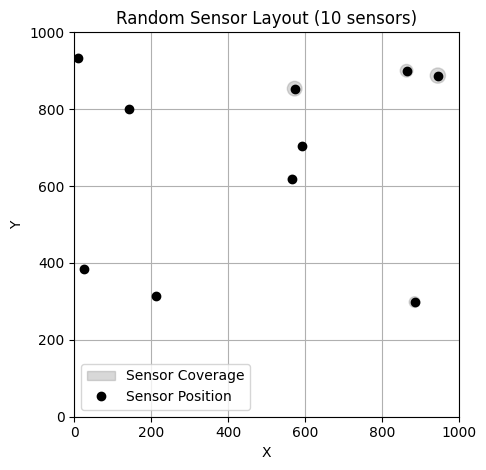

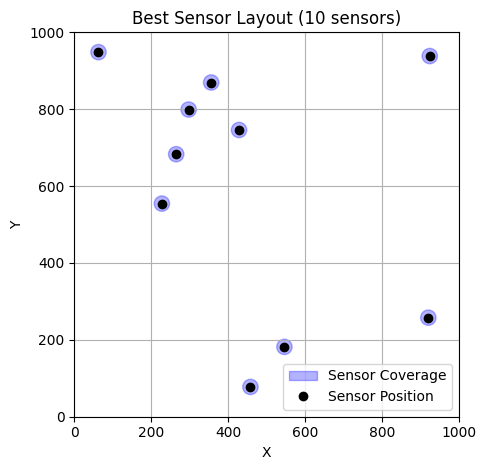

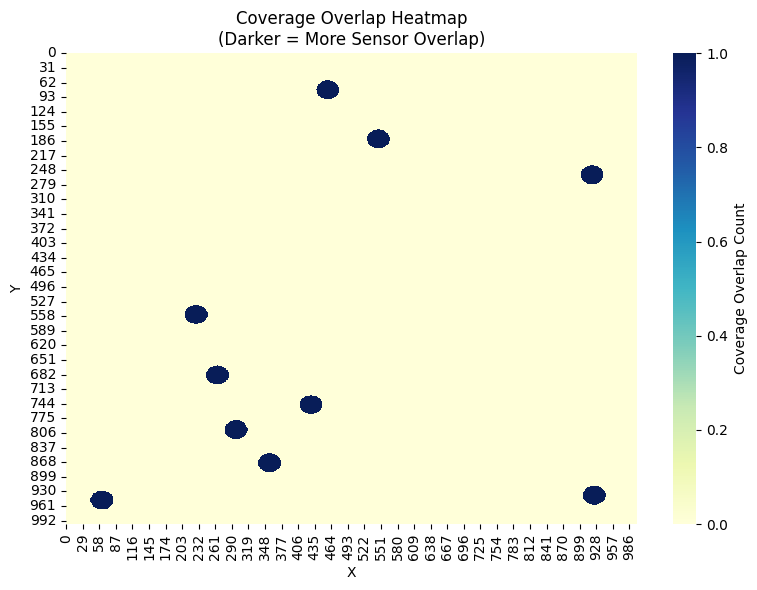

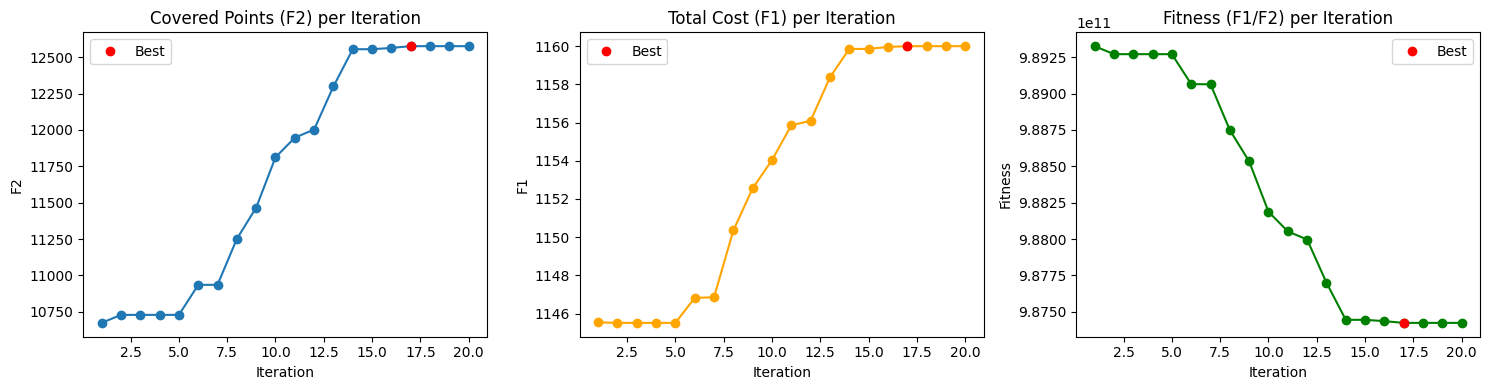

In [1]:
#!/usr/bin/env python3
# hybrid_sensor_layout.py
# ------------------------------------------------------------
#  Environmentally context-aware PSO-GA sensor placement demo
# ------------------------------------------------------------

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time

t0 = time.perf_counter()

# ================== 1. user input ==================
area_width   = int(input("Enter area width  (e.g. 100) : "))
area_height  = int(input("Enter area height (e.g. 100) : "))
sensor_count = int(input("Enter number of sensors (e.g. 5): "))
r_min        = float(input("Enter minimum radius (e.g. 5) : "))
r_max        = float(input("Enter maximum radius (e.g. 20): "))
fixed_cost   = float(input("Enter fixed part cost per sensor (e.g. 10): "))

# ================== 2. constants & constraints ==================
COST_PER_RADIUS  = 0.8      # variable cost per unit radius (C_h term)
MIN_COVERAGE_REQ = 1        # a_i: minimum coverage count per grid cell
PENALTY_FACTOR   = 1e6      # penalty if a cell is under-covered
EPS              = 1e-6     # avoid division by zero

# ================== 3. PSO hyper-parameters ==================
SWARM_SIZE   = 30
MAX_ITER     = 20
W_INERTIA    = 0.7          # inertia weight
C_COGNITIVE  = 1.5          # cognitive factor
C_SOCIAL     = 1.5          # social factor
V_MAX_FACTOR = 0.2          # velocity cap as a fraction of (ub-lb)

# ================== 4. simulated-annealing hyper-parameters ==================
SA_STEPS = 100
T0       = 1.0
ALPHA    = 0.95             # temperature decay

# ================== 5. grid pre-processing ==================
grid_res = 1
x_coords = np.arange(0, area_width , grid_res)
y_coords = np.arange(0, area_height, grid_res)
xx, yy   = np.meshgrid(x_coords, y_coords)
GRID     = np.c_[xx.ravel(), yy.ravel()]          # shape (n_pts, 2)

dim = sensor_count * 3                            # particle dimension

# ================== 6. fitness function (core change)  ==================
def fitness(vec):
    """
    Return: (fitness = F1/F2 + penalty, heatmap)
    vec  = [x1, y1, r1, x2, y2, r2, ...]
    F1   = total deployment cost (eq. 1)      – minimise
    F2   = #grid cells covered ≥ a_i (eq. 3)  – maximise
    Fitness = F1 / F2  (eq. 4)                – PSO/SA minimises this
    """
    total_cost = 0.0
    cover_cnt  = np.zeros(len(GRID), dtype=int)   # coverage count per cell

    for i in range(sensor_count):
        x, y, r = vec[i*3:i*3+3]
        dist    = np.hypot(GRID[:, 0] - x, GRID[:, 1] - y)
        covered = dist <= r
        cover_cnt += covered.astype(int)

         # C_h = fixed cost + r * variable cost
        total_cost += fixed_cost + COST_PER_RADIUS * r

    F1 = total_cost
    F2 = np.sum(cover_cnt >= MIN_COVERAGE_REQ)

    ratio   = F1 / (F2 + EPS)                    # eq. 4
    penalty = PENALTY_FACTOR * np.sum(cover_cnt < MIN_COVERAGE_REQ)

    return ratio + penalty, cover_cnt

# ================== 7. particle initialisation ==================
lb = np.tile([0,          0,          r_min ], sensor_count)
ub = np.tile([area_width, area_height, r_max ], sensor_count)
v_max = (ub - lb) * V_MAX_FACTOR

pos = np.random.uniform(lb, ub, (SWARM_SIZE, dim))
vel = np.random.uniform(-v_max, v_max, (SWARM_SIZE, dim))

pbest_pos = pos.copy()
pbest_val = np.full(SWARM_SIZE, np.inf)

gbest_pos  = None
gbest_val  = np.inf
gbest_heat = None

# ================== 8. history containers ==================
fitness_hist, coverage_hist, cost_hist = [], [], []
pos_hist = []

# ================== 9. main loop: PSO + SA  ==================
for it in range(1, MAX_ITER + 1):

    # ------- 9.1 evaluate the entire swarm -------
    for i in range(SWARM_SIZE):
        f_val, heat = fitness(pos[i])

        if f_val < pbest_val[i]:
            pbest_val[i] = f_val
            pbest_pos[i] = pos[i].copy()

        if f_val < gbest_val:
            gbest_val, gbest_pos, gbest_heat = f_val, pos[i].copy(), heat.copy()

    # ------- 9.2 local search: simulated annealing around gbest -------
    current, current_val, current_heat = gbest_pos.copy(), gbest_val, gbest_heat
    T = T0
    for _ in range(SA_STEPS):
        neighbor = current + np.random.normal(0, 0.1, dim) * (ub - lb)
        neighbor = np.clip(neighbor, lb, ub)
        n_val, n_heat = fitness(neighbor)
        delta = n_val - current_val
        if delta < 0 or np.random.rand() < np.exp(-delta / T):
            current, current_val, current_heat = neighbor, n_val, n_heat
        T *= ALPHA
    if current_val < gbest_val:
        gbest_pos, gbest_val, gbest_heat = current, current_val, current_heat

    # ------- 9.3 PSO position/velocity update -------
    r1, r2 = np.random.rand(SWARM_SIZE, dim), np.random.rand(SWARM_SIZE, dim)
    vel = (W_INERTIA * vel
           + C_COGNITIVE * r1 * (pbest_pos - pos)
           + C_SOCIAL    * r2 * (gbest_pos - pos))
    vel = np.clip(vel, -v_max, v_max)
    pos = np.clip(pos + vel, lb, ub)

    # ------- 9.4 log history -------
    g_heat = gbest_heat
    g_cost = 0.0
    for j in range(sensor_count):
        _, _, r = gbest_pos[j*3:j*3+3]
        g_cost += fixed_cost + COST_PER_RADIUS * r

    fitness_hist .append(gbest_val)
    coverage_hist.append(np.sum(g_heat >= MIN_COVERAGE_REQ))  # F2
    cost_hist    .append(g_cost)                              # F1
    pos_hist     .append(gbest_pos.copy())

    # ------- 可选输出 -------
    # print(f"iter {it:02d}: best Fitness={gbest_val:.4f}")

print(f"Stopping search: reached max iterations ({MAX_ITER})")
print(f"Best Fitness = {gbest_val:.4f}")

# ================== 10. final stats ==================
final_cover_cnt = gbest_heat
final_f2        = np.sum(final_cover_cnt >= MIN_COVERAGE_REQ)
final_cost      = 0.0
for i in range(sensor_count):
    _, _, r = gbest_pos[i*3:i*3+3]
    final_cost += fixed_cost + COST_PER_RADIUS * r

print(f"\n Final Covered Points (F2): {final_f2}")
print(f" Total Cost (F1)          : {final_cost:.2f}")
print(f" Cost per Covered Point   : {gbest_val:.4f}")

hybrid_elapsed = time.perf_counter() - t0
print(f"⏱ Hybrid runtime: {hybrid_elapsed:.2f} s")

# ================== 11-bis. random baseline  ==================
rand_pos = np.zeros_like(gbest_pos)
for i in range(sensor_count):
    rand_pos[i*3]     = np.random.uniform(0, area_width)
    rand_pos[i*3 + 1] = np.random.uniform(0, area_height)
    rand_pos[i*3 + 2] = np.random.uniform(r_min, r_max)

rand_val, rand_heat = fitness(rand_pos)
rand_f2   = np.sum(rand_heat >= MIN_COVERAGE_REQ)
rand_cost = 0.0
for i in range(sensor_count):
    _, _, r = rand_pos[i*3:i*3+3]
    rand_cost += fixed_cost + COST_PER_RADIUS * r

print("\n--- RANDOM BASELINE ---")
print(f"Covered Points (F2): {rand_f2}")
print(f"Total Cost (F1)   : {rand_cost:.2f}")
print(f"Fitness           : {rand_val:.4f}")

# ================== 12. visualisation: layout plots ==================
def plot_layout(title, positions, heatmap, color):
    fig, ax = plt.subplots()
    ax.set_xlim(0, area_width)
    ax.set_ylim(0, area_height)
    ax.set_aspect('equal')
    ax.set_title(title)
    for i in range(sensor_count):
        x, y, r = positions[i*3:i*3+3]
        ax.add_patch(plt.Circle((x, y), r, color=color, alpha=0.3,
                                label='Sensor Coverage' if i == 0 else ""))
        ax.plot(x, y, 'ko', label='Sensor Position' if i == 0 else "")
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(dict(zip(labels, handles)).values(),
              dict(zip(labels, handles)).keys())
    plt.grid(True)
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.tight_layout()
    plt.show()

plot_layout(f'Random Sensor Layout ({sensor_count} sensors)', rand_pos, rand_heat, 'gray')
plot_layout(f'Best Sensor Layout ({sensor_count} sensors)',   gbest_pos, gbest_heat, 'blue')

# ================== 13. visualisation: overlap heatmap ==================
heatmap = gbest_heat.reshape(len(y_coords), len(x_coords))
plt.figure(figsize=(8, 6))
sns.heatmap(heatmap, cmap='YlGnBu',
            cbar_kws={'label': 'Coverage Overlap Count'})
plt.title('Coverage Overlap Heatmap\n(Darker = More Sensor Overlap)')
plt.xlabel('X')
plt.ylabel('Y')
plt.tight_layout()
plt.show()

# ================== 14. visualisation: convergence curves ==================
best_iter = np.argmin(fitness_hist)
iters = np.arange(1, MAX_ITER + 1)

plt.figure(figsize=(15, 4))
plt.subplot(1, 3, 1)
plt.plot(iters, coverage_hist, 'o-')
plt.plot(iters[best_iter], coverage_hist[best_iter], 'ro', label='Best')
plt.title("Covered Points (F2) per Iteration")
plt.xlabel("Iteration")
plt.ylabel("F2")
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(iters, cost_hist, 'o-', color='orange')
plt.plot(iters[best_iter], cost_hist[best_iter], 'ro', label='Best')
plt.title("Total Cost (F1) per Iteration")
plt.xlabel("Iteration")
plt.ylabel("F1")
plt.legend()

plt.subplot(1, 3, 3)
plt.plot(iters, fitness_hist, 'o-', color='green')
plt.plot(iters[best_iter], fitness_hist[best_iter], 'ro', label='Best')
plt.title("Fitness (F1/F2) per Iteration")
plt.xlabel("Iteration")
plt.ylabel("Fitness")
plt.legend()

plt.tight_layout()
plt.show()
